## Figure 8. Comparing RDD for different network depths

Imports

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF_Recurrent, ParamsLIF_Recurrent
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Angle between two vectors
def alignment(a,b):
    da = np.dot(a,a)
    db = np.dot(b,b)
    if da > 0 and db > 0:
        return 180/np.pi*np.arccos(np.dot(a,b)/np.sqrt(da*db))
    else:
        return 360.
    
def mse(pred,true):
    return np.mean((pred - true)**2)

In [3]:
#Test LIF_Recurrent network
nsims = 1

cvals = [0.0, 0.7]
pvals = np.logspace(-2, 0, 10)
#c = 0.9
n1 = 200
n2 = 10
tau_s = 0.020
dt = 0.001
t = 1   #In seconds
sigma = 10
x = 0
#p = 0.1
DeltaT = 10

nC = len(cvals)
nP = len(pvals)

t_filter = np.linspace(0, 1, 1000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

params = ParamsLIF_Recurrent(exp_filter, sigma = sigma,sigma1=0.1, n1 = n1, n2 = n2)
lif = LIF_Recurrent(params, t = t)

In [4]:
params

## Test 2 hidden layer network

In [5]:
inp,v, h, u, sh = lif.simulate()
#bp,hidd=lif.backprop()
# results=lif.simulate()
#np.nonzero(results[3][0,:])[0].shape

(784, 1000)
(200,)
('e shape:', (10, 1))
('dLdu shape:', (10, 200))
('dLdw shape:', (200, 784))
(784, 1000)
(200,)
('e shape:', (10, 1))
('dLdu shape:', (10, 200))
('dLdw shape:', (200, 784))


In [6]:
# for i in range(784):
#     plt.plot(x[i,:])
#     plt.show()

In [7]:
sh.shape

(210, 1000)

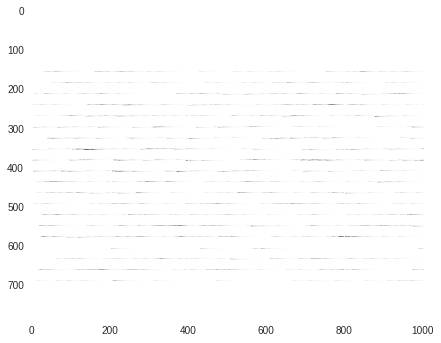

In [8]:
plt.imshow(inp[1,:,:])


In [9]:
#print('Firing rates:',np.sum(h[0], 1)/t)

TypeError: Invalid dimensions for image data

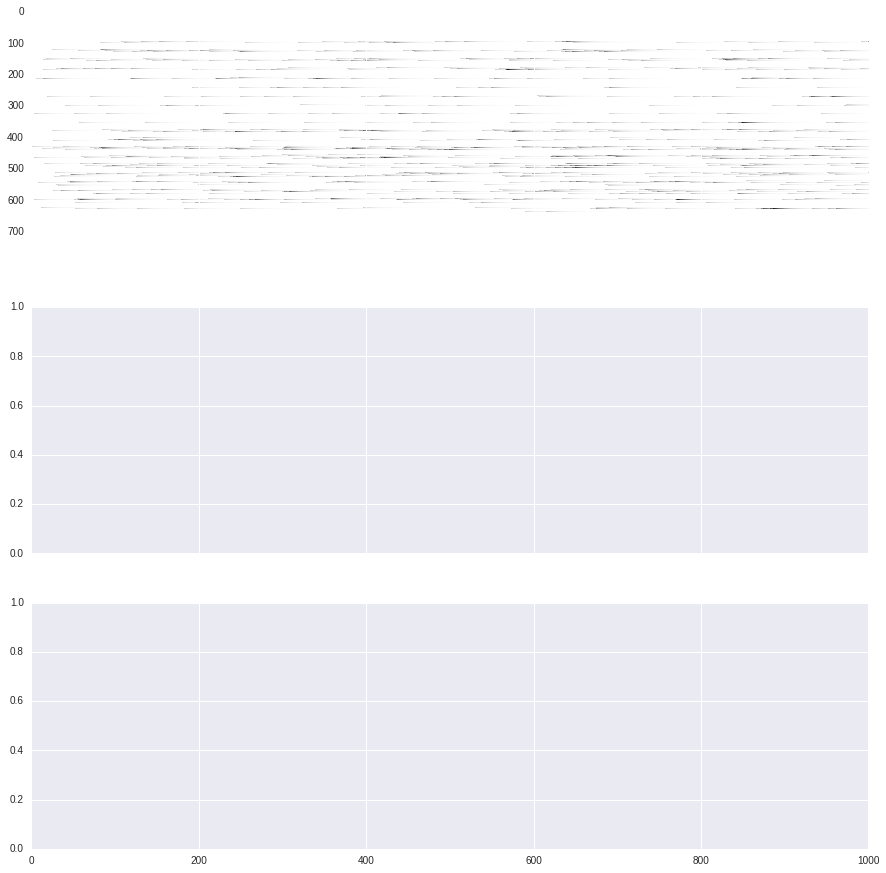

In [10]:
fig, axes = plt.subplots(3,1,figsize = (15, 15), sharex = True)
axes[0].imshow(inp[0], aspect = 'auto', interpolation = 'nearest')
axes[1].imshow(v[0], aspect = 'auto', interpolation = 'nearest')
im2 = axes[2].imshow(h[0], aspect = 'auto', interpolation = 'nearest')
axes[0].set_ylabel('voltage')
axes[1].set_ylabel('spike raster')
axes[2].set_ylabel('synaptic input')
axes[2].set_xlabel('time bin')
plt.colorbar(im2, ax = axes[2])

In [ ]:
v[0]

In [ ]:
v[0,-10::]

## Causal effect estimation

In [ ]:
U = np.eye(n2)
target = .02*np.ones((n2,1))
target[0] = 0
C_orig = lambda s: np.sum((np.dot(U, s) - target)**2,0)
nsims = 50
beta_rd_c = np.zeros((nC, nsims, nP, n1))
beta_rd_c_linear = np.zeros((nC, nsims, nP, n1))
beta_fd_c = np.zeros((nC, nsims, nP, n1))
beta_fd_c_linear = np.zeros((nC, nsims, nP, n1))

In [ ]:
cvals

In [ ]:
#Compute causal effects
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in range(nsims):
        (inp,v, h, u, sh) = lif.simulate(DeltaT)
        cost = C_orig(sh[n1:,:])
        for k,p in enumerate(pvals):
            #a = causaleffect_maxv(u[0:n1,:], cost, DeltaT, p, params)
            #print(a.shape)
            beta_rd_c[i,j,k,:] = causaleffect_maxv(u[0:n1,:], cost, DeltaT, p, params)
            beta_rd_c_linear[i,j,k,:] = causaleffect_maxv_linear(u[0:n1,:], cost, DeltaT, p, params)
        beta_fd_c[i,j,:] = causaleffect_maxv(u[0:n1,:], cost, DeltaT, 1, params)
        beta_fd_c_linear[i,j,:] = causaleffect_maxv_linear(u[0:n1,:], cost, DeltaT, 1, params)

In [ ]:
#Plot the causal effects as a function of p
for u in range(10):
    #u = 1
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    #for i in range(len(cvals)):
    #    #sns.tsplot(data = beta_rd_c[i,:,:,u], ax = ax, ci='sd', time=pvals)#, color='C%d'%i)
    #    sns.tsplot(data = beta_rd_c[i,:,:,u], ax = ax, time=pvals)#, color='C%d'%i)
    #    #ax.plot(pvals, m_beta_rd_c[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
    sns.tsplot(data = beta_rd_c[0,:,:,u], ax = ax, time=pvals, color='red')
    sns.tsplot(data = beta_rd_c[1,:,:,u], ax = ax, time=pvals, color='blue')
    #sns.tsplot(data = beta_rd_c_linear[0,:,:,u], ax = ax, time=pvals, color='red')
    #sns.tsplot(data = beta_rd_c_linear[1,:,:,u], ax = ax, time=pvals, color='blue')
    ax.set_xlabel('window size $p$');
    ax.set_ylabel('average causal effect');
    ax.set_title('Constant RD estimator');
    #ax.plot(pvals, beta_sp_c[0,u]*ones(pvals.shape), color=(0,0,0));
    #ax.set_ylim([3, 7])
    #ax.set_ylim([5.4, 5.9])
    #ax.set_xlim([0, 1])
    ax.set_xscale('log')
    #ax.set_yticks([2, 3, 4, 5, 6])
    sns.despine(trim=True)
    ax.legend(["c = %.2f"%i for i in cvals]);
    #plt.savefig('./fig_2a.pdf')

## A. Dependence on $N$ and $c$

In [ ]:
nsims = 5
cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
#cvals = np.array([0.01, 0.25, 0.5])
#Nvals = np.logspace(1, 3, 6, dtype = int)
Nvals = np.logspace(1, 3, 4, dtype = int)

tau_s = 0.020
dt = 0.001
t = 100
sigma = 10
x = 0
p = 0.1
DeltaT = 20

W = np.array([12, 9])

params = ParamsLIF(sigma = sigma)
lif = LIF(params, t = t)
lif.W = W

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#c (correlation between noise inputs)
beta_mse_rd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_bp_c = np.zeros((len(cvals), len(Nvals), nsims))

beta_mse_rd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))

In [ ]:
#beta_sp_c = np.zeros((len(cvals), params.n))

target = 0.1
W = 10*np.ones(int(Nvals[-1]))
#W = np.random.randn(int(Nvals[-1]))*5
V = np.random.randn(int(Nvals[-1]))*5

cost = lambda s,a: (np.dot(a[0:len(s)], s) - len(s)*target)**2

#Cost function
#B1 = 1
#B2 = 2
#x = .01
#y = 0.1
#z = 0

#cost = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

In [ ]:
params.c = 0.99
params.n = 10
lif.setup(params)
lif.W = W[0:10]
(v, h, _, _, u) = lif.simulate(DeltaT)

In [ ]:
h.shape
n_units = 10
s = np.zeros(h.shape)
for l in range(10):
    s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
cost_s = cost(s,V[0:n_units])